# Questions about free energy calculations 

In this notebook, we describe our questions about free energy calculations using the block bootstrap method. In a nutshell, we are mainly wondering about the best strategies for deciding how much we should truncate a simulation and how much we should average the biasing potential for reweighting. Below we first demonstrate our workflow for free energy calculations. Then, we'll show the results we got from two different systems we plan to present in our paper. In each folder of `System_2` and `System_3`, we store relevant files such as `plumed.dat`, `plumed_sum_bias.dat`, and `calculate_free_energy.py`. For each system, the HILLS and COLVAR files (which are the inputs for free energy calculations by `calculate_free_energy.py`) can be accessed via [this link](https://drive.google.com/drive/folders/1Pf-XI0Hm9O2v0OBJufHzH1ItrUXFW34f?usp=sharing) as interested/needed. Notably, the input files are huge (~5 GB in total) and a free energy calculation (with several different block sizes) could take up to several hours and 30 GB of memory. In each folder, we also attach text files documenting the results of free energy calculations with different sets of parameters. 

## Our protocol for free energy calculations 

To provide more details about our protocol for free energy calculations, here we take the solvation free energy calculation (200 ns) from the 2D alchemical metadynamics of System 2 as an example. System 2 is a system composed of 4 interaction sites shown below. Its two metastable states can be differentiated by the only dihedral angle of the system. In the simulation, in addition to the alchemical variable, we biased this dihedral angle.

<center>
<img src=https://i.imgur.com/PmJsmoj.png width=350>
</center>

In 2D alchemical metadynamics simulation, the following PLUMED input file was used:

In [1]:
%%bash 
cat System_2/plumed.dat

theta: TORSION ATOMS=1,2,3,4
lambda: EXTRACV NAME=lambda

METAD ...
ARG=theta,lambda 
SIGMA=0.5,0.0001     # small SIGMA ensure that the Gaussian approaximate a delta function
HEIGHT=4.955418079891953    # kJ/mol
PACE=500        
GRID_MIN=-pi,0   # index of alchemical states starts from 0
GRID_MAX=pi,19   # we have 20 states in total
GRID_BIN=100,19
TEMP=298
BIASFACTOR=120
LABEL=metad    
FILE=HILLS_2D
... METAD

PRINT STRIDE=10 ARG=theta,lambda,metad.bias FILE=COLVAR


To perform free energy calculations for such a simulation, in the folder `System_2`, we can simply execute the following one command:
```
python calculate_free_energy.py -d ./ -n 200 500 1000 2000 -hh HILLS_2D -t 0.3 -a 0.2
```

The method used in `calculate_free_energy.py` is the same as the protocol suggested by Dr. Bussi in  [Check.ipynb](https://github.com/wehs7661/lambda_MetaD_questions/blob/master/archived_questions/210314_questions/Method_1/Check.ipynb). `calculate_free_energ.py` has more lines just to monitor memory usage, print organized results, make the calculation more memory efficient, and fix corrupted PLUMED output files as needed, etc. Assuming the arguments passed by the command shown above, `calculate_free_energy.py` performs the method by following the steps below: 
- **Step 1**: Modify the `HILLS_2D` file and save as `HILLS_2D_modified`
  - With `-a 0.2`, we average the last 20% of the biasing potential using the function `average_bias` (which is basically the same as the function `time_average` in `Check.ipynb`). The function updates the second last column (`height`) dataframe read from `HILLS_2D` (the HILLS file of the simulation). We then write this updated dataframe as `HILLS_2D_modified`.
- **Step 2**: Calculate the unbiasing weight based on the time-averaged biasing potential
  - The code first runs plumed driver with the input file `plumed_sum_bias.dat` to sum up the heights in `HILLS_2D_modified`. Specifically, plumed driver reads in `COLVAR` and `HILLS_2D_modified`, calculates the biasing potential averaged over the last 20% of the simulation (by summing up the heights in `HILLS_2D_modified`), and outputs `COLVAR_SUM_BIAS`. In `COLVAR_SUM_BIAS`, the last column `metad.bias` is the time-averaged bias, which will be subtracted with its maximum later in the function `block_boostrap` to serve as the unbiasing weight for reweighting. 
  - For System 2, below is the content of `plumed_sum_bias.dat`:

In [2]:
%%bash
cat System_2/plumed_sum_bias.dat

theta: READ FILE=COLVAR VALUES=theta IGNORE_TIME IGNORE_FORCES
lambda: READ FILE=COLVAR VALUES=lambda IGNORE_TIME IGNORE_FORCES

METAD ...
ARG=theta,lambda 
SIGMA=0.5,0.0001     # small SIGMA ensure that the Gaussian approaximate a delta function
HEIGHT=0     
PACE=50000000    
GRID_MIN=-pi,0   # index of alchemical states starts from 0
GRID_MAX=pi,19   # we have 20 states in total
GRID_BIN=100,19
TEMP=298
BIASFACTOR=60
LABEL=metad    
FILE=HILLS_2D_modified
RESTART=YES
... METAD

PRINT STRIDE=1 ARG=theta,lambda,metad.bias FILE=COLVAR_SUM_BIAS


- **Step 3**: Perform block bootstrap to calculate the free energy difference and the corresponding uncertainty
  - Lastly, the code performs block bootstrap by running the function `block_bootstrap`, which is basically the same as the function `analyze` in `Check.ipynb`. 
  - In this case, the function first truncates the first 30% of the CV time series and then construct histograms/perform bootstrapping. 

## Free energy calculations of System 2

As a result, we have the following free energy estimates given different average fractions and truncation fractions. The uncertainties reported below are the biggest uncertainties among trials with different block sizes. For more details, please refer to files named as `fes_results_*.dat` in the folder `System_2`. 

| Attempt | Avg fraction | Truncation | Free energy difference |
|---------|--------------|------------|------------------------|
|    1    |      0.3     |      0     |   -0.820 +/- 0.038 kT  |
|    2    |      0.4     |      0     |   -0.830 +/- 0.034 kT  |
|    3    |      0.2     |     0.2    |   -0.680 +/- 0.035 kT  |
|    4    |      0.2     |     0.5    |   -0.710 +/- 0.044 kT  |
|    5    |      0.3     |     0.5    |   -0.841 +/- 0.049 kT  |

In this case, I tried different sets of average and truncation fractions. (I assume that a better truncation fraction should at least ensure that only the samples in the stationary region are considered in the analysis.)

<center>
<img src=https://i.imgur.com/clgc97T.png width=350>
</center>

As can be seen from the table, different average fractions and truncation fractions led to different results. **With this, we are wondering if there is a more rigorous strategy to determine what average or truncation fractions to use, i.e. which single value in the table above makes the most sense to be reported in the paper?**

## Free energy calculations of System 3

In System 3 (a host-guest binding complex in the SAMPL6 SAMPLing challenge), we used 2D alchemical metadynamics (200 ns) to calculate the free energy difference of the alchemical process of decoupling the interactions between the guest molecule and the host molecule, which was a part of the thermodynamic cycle for calculating the binding free energy for the binding complex. In the 2D simulation, the configurational CV was the number of water molecules in the binding cavity (denoted as $N$). In the bound state and the unbound states, typically there are 0.7-5.3 and 4.5-10.5 water molecules in the binding cavity, respectively. Therefore, we set a potential at $N=0.7$ and $N=10.5$, respectively. Since the sampling in regions like $N<0.7$ or $N>10.5$ is likely to be unphysical, we discarded the samples in such regions. (Specifically, when calculating the unbiasing weights for reweighting using `average_bias`, we ignore unphysical samples. We also discard the unphysical samples from `COLVAR_SUM_BIAS` when constructing the histograms.)

Below is the content of the PLUMED input file for the simulation. 

In [3]:
%%bash
cat System_3/plumed.dat

center: CENTER ATOMS=1-144            # geometric center of the host molecule
water_group: GROUP ATOMS=207-6656:3   # oxygen atom of the water molecules
n: COORDINATION GROUPA=center GROUPB=water_group R_0=0.35  # radius: 0.6 nm
lambda: EXTRACV NAME=lambda

METAD ...
ARG=lambda,n
SIGMA=0.01,0.05    # small SIGMA ensure that the Gaussian approaximate a delta function
HEIGHT=12.394781044629076
PACE=10
GRID_MIN=0,0     # index of alchemical states starts from 0
GRID_MAX=39,20     # we have 40 states in total
GRID_BIN=39,100
TEMP=298
BIASFACTOR=150
LABEL=metad
FILE=HILLS_2D
... METAD

UPPER_WALLS ...
 ARG=n
 AT=10.5
 KAPPA=200.0
 EXP=2
 EPS=1
 OFFSET=0
 LABEL=uwall
... UPPER_WALLS

LOWER_WALLS ...
 ARG=n
 AT=0.7
 KAPPA=200.0
 EXP=2
 EPS=1
 OFFSET=0
 LABEL=lwall
... LOWER_WALLS

PRINT STRIDE=10 ARG=* FILE=COLVAR


To have a better sense of how much we should truncate the simulation and how much we should average the biasing potentials in free energy calculations, here we first examine the Gaussian bias as a function of time. Notably, in the left figure, the spikes come from the rarely-visited, unphysical regions. After discarding data with $N<0.7$ or $N>10.5$, the decrease of the Gaussian bias is smooth, as shown in the right figure.
<center>
<img src=https://i.imgur.com/j7XVSnu.png width=800>
</center>

The Gaussian bias became more stationary around 60-100 ns, so in addition to the truncation fraction of 0, we also adopted 0.3 and 0.5. For the average fraction, we tried values such as 0.2, 0.3, and 0.4. Below we tabulate the estimates of the free energy difference.


| Attempt | Avg fraction | Truncation | Free energy difference |
|---------|--------------|------------|------------------------|
|    1    |      0.2     |      0     |  135.732 +/- 0.186 kT  |
|    2    |      0.3     |      0     |  134.823 +/- 0.156 kT  |
|    3    |      0.4     |      0     |  137.763 +/- 0.370 kT  |
|    4    |      0.2     |     0.3    |  135.727 +/- 0.229 kT  |
|    5    |      0.3     |     0.3    |  134.824 +/- 0.218 kT  |
|    6    |      0.4     |     0.3    |   137.840 +/- 0.561kT   |
|    7    |      0.2     |     0.5    |   135.743 +/- 0.351kT   |
|    8    |      0.3     |     0.5    |   134.831 +/- 0.260kT   |
|    9    |      0.4     |     0.5    |      137.71 +/- 0.716kT|

Regarding the results shown above, we have the following questions:
- Same as the question we had for System 2, we are wondering if there is a good strategy for choosing values of average fraction or truncation fraction. 
- The results above lead to a total binding free energy (considering the free energy difference obtained from the ligand simulation and a correction term) around -3.45~-5.24 kcal/mol, which are far from the references in the SAMPL6. Specifically, below are the more useful references in the paper:
  - The longest simulations in the SAMPL6 paper:
    - OpenMM/HREX, 4$\mu$s: -10.8 +/- 0.2 kcal/mol
    - GROMACS/NS-DS/SB-long, 4 $\mu$s: -11.3 +/- 0.2 kcal/mol
  - Experimental value: -6.45 +/- 0.06 kcal/mol
  From the Gaussian height and the sampling in either the alchemical or the configurational space (distributions shown below), we can't really identify the reason for this. While we are still looking into this issue, I'm wondering if you have any suggestions for us to look at and probably improve the simulation. (To get a binding free energy around -11 kcal/mol, the free energy difference obtained from the simulation presented above should have been around 145-146 kT.) Please let me know if you need further information. 
 
<img src=https://i.imgur.com/nyz2AVH.png width=800>
</center>

## Update
Dr. Bussi reported that the free energy difference between the coupled and uncoupled states calculated from `sum_hills` was around 150 kT, while the values shown above are all below 140 kT. To compare with Dr. Bussi's result, I've additionally run another attempt that adopted all samples with the average fraction and the truncation fraction both being 0, since `sum_hills` did not truncate or ignore any data. As a result, with 20 blocks, the free energy difference was 140.864 +/- 0.426 kT, which is still far from 150 kT. 

Just to be 100% sure, I used the following minimal code that was used in `Check.ipynb` to calculate the free energy difference for System 3:
```python
import plumed
import numpy as np
import matplotlib.pyplot as plt

def analyze(traj, n_blocks, discard=0):
    """
    This function returns average and error with bootstrap
    
    Parameters
    ----------
    traj (pandas.DataFrame): trajectory data (content of COLVAR)
    nblocks (int): number of blocks
    discard (float): discarded fraction
    """
    n = int(len(traj) * (1.0 - discard))   # number of data points considered
    # make sure the number of frames is a multiple of nblocks (discard the first few frames)
    n = (n // n_blocks) * n_blocks
    bias = np.array(traj["metad.bias"])
    bias -= np.max(bias) # avoid overflows
    w = np.exp(bias / kBT)[-n:].reshape((n_blocks, -1)) # shape: (nblocks, nframes in one block), weight for each point

    # A: coupled state, B: uncoupled state
    isA = np.int_(traj["lambda"] == 0)[-n:].reshape((n_blocks, -1)) # 1 if in A (np.in_ converts bool to 0 or 1)
    isB = np.int_(traj["lambda"] == np.max(traj["lambda"]))[-n:].reshape((n_blocks, -1)) # 1 if in B

    B = 200 # number of bootstrap iterations
    boot = np.random.choice(n_blocks, size=(B, n_blocks))  # draw samples from np.arange(n_blocks), size refers the output size
    popA = np.average(isA[boot], axis=(1,2), weights=w[boot])  # Note that isA[boot] is a 3D array
    popB = np.average(isB[boot], axis=(1,2), weights=w[boot])  # shapes of popA and popB: (B,)

    df = np.log(popA / popB) # this is in kBT units
    popA0 = np.average(isA, weights=w)
    popB0 = np.average(isB, weights=w)
    return np.log(popA0 / popB0), np.std(df)

if __name__ == "__main__":

    np.random.seed(0)
    kBT = 2.4777090399459767

    colvar_rew = plumed.read_as_pandas('COLVAR_SUM_BIAS')

    # block analysis
    dd = []
    nblocks = [2000, 1000, 500, 200, 50, 20]
    for nb in nblocks:
        dd.append(analyze(colvar_rew, nb, discard=0.0))
    dd=np.array(dd)
    print(dd)   # free energy difference and its uncertainty given different block sizes

```

Using the code above, we have the following results:

| Attempt | Block size  | Free energy difference |
|---------|--------------|------------------------|
|    1    |      20     |    140.864 +/- 0.371 kT  |
|    2    |      50     |    140.864 +/- 0.315 kT  |
|    3    |     200     |    140.864 +/- 0.219 kT  |
|    4    |     500     |    140.864 +/- 0.169 kT  |
|    5    |    1000     |    140.864 +/- 0.149 kT  |
|    6    |    2000     |    140.864 +/- 0.172 kT   |


In [4]:
import plumed 
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
fes_data = plumed.read_as_pandas('data/System_3/fes.dat')
f = np.array(fes_data['file.free']).reshape((101, 40))

<ipython-input-5-0fa656128a8b>:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  fes_data = plumed.read_as_pandas('data/System_3/fes.dat')


In [6]:
df = []
for i in range(len(f)):
    df.append((f[i][-1] - f[i][0]) / 2.4777090399459767)  # in kT

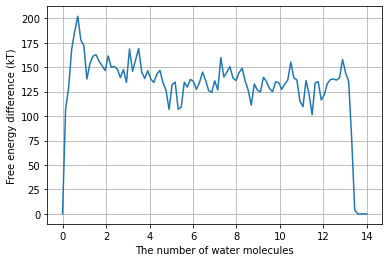

In [7]:
plt.figure()
plt.plot(np.unique(fes_data['n']), df)
plt.xlabel('The number of water molecules')
plt.ylabel('Free energy difference (kT)')
plt.grid()

In [8]:
df = np.array(df)
np.mean(df[df > 100])  # leave out the tail region (small and large N values)

139.14553354647722